# Tanvi's GLM
## Prep

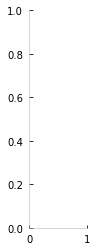

In [1]:
# HIDE CELL
from importlib import reload

import matplotlib.pylab as plt
import numpy as np

import deps
reload(deps)

alldat, dat_LFP, dat_ST = deps.get_data()
dat = alldat[0]

dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high

Dimensionality reduction - GPFA (data imported from MATLAB)


In [2]:
#Tanvi - 10 AM EST Jun 22
import scipy.io as sio
print(np.size(alldat))

for isession in range(len(alldat)):
    dd = alldat[isession]
    Y=np.transpose(dd['spks'],(1,0,2)); print(Y.shape)
    # sio.savemat(f'/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/Py2MATLAB_forGPFA/Py2MATLAB_forGPFA_{isession:d}.mat',{'Y':Y})
print('done')

39
(214, 734, 250)
(251, 1070, 250)
(228, 619, 250)
(249, 1769, 250)
(254, 1077, 250)
(290, 1169, 250)
(252, 584, 250)
(250, 1156, 250)
(372, 788, 250)
(447, 1172, 250)
(342, 857, 250)
(340, 698, 250)
(300, 983, 250)
(268, 756, 250)
(404, 743, 250)
(280, 474, 250)
(224, 565, 250)
(316, 1089, 250)
(247, 606, 250)
(235, 899, 250)
(124, 578, 250)
(444, 646, 250)
(151, 1268, 250)
(187, 1337, 250)
(261, 885, 250)
(178, 1056, 250)
(253, 563, 250)
(142, 549, 250)
(128, 750, 250)
(143, 942, 250)
(237, 977, 250)
(260, 522, 250)
(191, 613, 250)
(296, 781, 250)
(311, 795, 250)
(258, 680, 250)
(181, 1055, 250)
(199, 805, 250)
(343, 1348, 250)
done


In [3]:
%matplotlib inline
import pdb
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

gpfa_Y = loadmat('/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/gpfa_v0203/GPFA_reduced.mat')['gpfa_Y']
#gpfa_Y = loadmat('GPFA_reduced.mat')['gpfa_Y'] # Use this for google colab

xx=np.squeeze(gpfa_Y[0:2]).shape

f=plt.figure(figsize=(15,7))
for ifa in range(8):
  plt.subplot(2,4,ifa+1), 
  for it in range(5):
    plt.plot(gpfa_Y[it][ifa],'grey')
  plt.ylim([-3.2,3.2]); plt.xlabel('Time (*10 ms)')
  plt.title('Factor %i' %(ifa+1),loc='left')
# plt.suptitle('Factors from 8-dim GPFA reduction',fontsize=15)
# plt.savefig('gpfa_viz_session_11.jpg')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/gpfa_v0203/GPFA_reduced.mat'

In [ ]:
%matplotlib inline
from scipy.signal import savgol_filter

Y=dat['response']
gy1 = savgol_filter(np.mean(gpfa_Y[np.where(Y==-1)],axis=0),21,2)
gy2 = savgol_filter(np.mean(gpfa_Y[np.where(Y==1)],axis=0),21,2)

f = plt.figure(figsize=(7,5)); ax2 = f.add_subplot(111, projection='3d')
ax2.plot3D(gy1[0],gy1[1],gy1[2]); ax2.plot3D(gy2[0],gy2[1],gy2[2],color='red')
ax2.scatter3D(gy1[0][0],gy1[1][0],gy1[2][0],'x',color='blue'); ax2.scatter3D(gy2[0][0],gy2[1][0],gy2[2][0],'x',color='red')

f=plt.figure(figsize=(20,10))
plt.plot(gy1[0],gy1[1],color='blue'); plt.plot(gy2[0],gy2[1],color='red')
plt.plot(gy1[0][0],gy1[1][0],'x',color='green');plt.plot(gy2[0][0],gy2[1][0],'x',color='green')
plt.plot(gy1[0][51],gy1[1][51],'o',color='black');plt.plot(gy2[0][51],gy2[1][51],'o',color='black')
plt.plot(gy1[0][131],gy1[1][131],'+',color='black');plt.plot(gy2[0][131],gy2[1][131],'+',color='black')

In [ ]:
gy1[0][0]


Classification of GPFA reduced data using Naive Bayes classifier

In [ ]:
'''
TO DO: Plot GPFA weights corresponding to each individual brain area across ALL sessions

(A) Gather weights from all sessions
(B) Gather brain_area from all sessions
(C) Plot mean weights by brain_areas (next cell)
(D) Plot mean weights by bigger brain groups (cell after next)

'''
from scipy.io import loadmat
from tqdm import tqdm
import numpy.matlib as npm
# determine weights (neurons to latent_state) from GPFA and what brain regions they correspond to

C_all_tmp = np.empty(shape=(100000,8),dtype=object)
reduced_Y_tmp = np.empty(shape=(100000,8,25),dtype=object)

brain_area_tmp, choice_all_tmp = [np.empty(shape=(100000), dtype=object) for _ in range(2)]
direc = '/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/MATLAB2Py_afterGPFA/'

idx_start = 0; idx_startY = 0
for isession in tqdm(range(39)):
    fname = direc + 'GPFA_red_' + str(isession+1)+'.mat' # Files from MATLAB are just returned with one index misplaced
    try:
        C = loadmat(fname)['C']
        reduced_Y = loadmat(fname)['gpfa_Y']
        n_neuron = len(C); n_trials = len(reduced_Y)
        C_all_tmp[idx_start:(idx_start+n_neuron),:] = C
        reduced_Y_tmp[idx_startY:(idx_startY+n_trials),:,:] = reduced_Y
        
        dat = alldat[isession]
        brain_area_tmp[idx_start:(idx_start+n_neuron)] = dat['brain_area'][0:n_neuron]
        choice_all_tmp[idx_startY:(idx_startY+n_trials)] = dat['response'][0:n_trials]
        
        idx_start = idx_start + n_neuron
        idx_startY = idx_startY + n_trials
    except:
        print(fname + ' not found')
#         pdb.set_trace()

C_all = C_all_tmp[0:idx_start,:]
brain_area_all = brain_area_tmp[0:idx_start]

reduced_Y_all = reduced_Y_tmp[0:idx_startY,:,:]
choice_all = choice_all_tmp[0:idx_startY]

print('----- All weights from GPFA: C[n_neuron x 8 ] -----')
print(C_all.shape)


In [ ]:
'''
TO DO: Plot GPFA weights corresponding to each individual brain area across ALL sessions

(C): Plot mean weights: sorted by ICA grouping (import this from Jun's part of the code) 

'''
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]

sorted_brain_groups = [ ['VISrl', 'VISl', 'VISpm', 'VISp', 'VISa', 'VISam'],
['POL', 'MG', 'PT', 'LP', 'LGd', 'SPF', 'LD', 'PO', 'MD', 'VAL', 'VPL', 'VPM', 'TH','RT', 'CL', 'LH'],
['CA', 'CA2', 'CA3', 'POST', 'CA1', 'SUB', 'DG'],
['DP', 'COA', 'ILA', 'ORBm', 'RSP', 'OLF', 'PL', 'ACA', 'MOs', 'MOp', 'SSs', 'SSp','ORB', 'PIR', 'AUD', ' TT'],
['SCsg', 'NB', 'APN', 'PAG', 'SCs', 'SCig', 'MRN', 'IC', 'SCm', 'MB', 'RN', 'ZI'],
['LSc', 'LS', 'LSr', 'MS', 'ACB', 'GPe', 'OT', 'CP', 'SI', 'SNr'],
['BMA', 'EP', 'EPd', 'MEA', 'BLA'] ]


all_brain_groups = []; all_area = []
for sublist in range(len(sorted_brain_groups)):
    for item in range(len(sorted_brain_groups[sublist])):
        all_brain_groups.append(sorted_brain_groups[sublist][item])
        all_area.append(sublist)

        
# col_list = ['blue','green','red','cyan','magenta','yellow','black']
col_list=['b', 'g', 'r', 'c', 'm', 'y', 'k']
which_color=1
f = plt.figure(figsize=(20,10))
for ifa in range(3):
    for ib in range(len(all_brain_groups)):
        which_color=all_area[ib]
        plt.subplot(3,1,ifa+1)
        
        idx_by_brain=brain_area_all == all_brain_groups[ib]
        
        try:
            if np.sum(idx_by_brain)==0:
                yy=0
            else:
                yy=np.mean(np.abs(C_all[idx_by_brain,ifa]))
        except:
            pdb.set_trace()
                
        plt.bar(ib, yy,color=col_list[which_color])
        plt.xticks(range(len(all_brain_groups)),all_brain_groups,rotation='vertical',fontsize=12)
        plt.title(f"Factor {ifa:d}", fontsize=15); plt.ylabel('Weights',fontsize=12)

for icol in range(len(col_list)):
    plt.plot(np.inf,np.inf,color=col_list[icol],linewidth=2,label=regions[icol])
    plt.legend(loc='upper left')
plt.suptitle('GPFA weights',y=1.1,fontsize=20)
# plt.savefig('GPFA weights_smallbrain')
plt.show()



In [ ]:
'''
TO DO:

(D) Plot mean weights by bigger brain groups (cell after next)
'''
nareas = len(regions)-1 
NN = len(brain_area_all) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(brain_area_all, sorted_brain_groups[j])] = j # assign a number to each region

print(barea.shape)
f=plt.figure(figsize=(15,7))

for ifa in range(3):
    for j in range(nareas):
        plt.subplot(1,3,ifa+1)
        
        try:
            yy = np.mean(np.abs(C_all[barea==j,ifa]))
            plt.bar(j,yy, color=col_list[j],label=regions[j])
            plt.title(f"Factor {ifa:d}", fontsize=15); plt.ylabel('Weights',fontsize=12)
        except:
            pdb.set_trace()
            
    plt.xticks(range(len(regions)-1),regions[:-1],rotation='vertical',fontsize=12)

plt.suptitle('GPFA weights: Coarser brain regions',y=1.1,fontsize=20)
# plt.savefig('GPFA weights_bigbrain')
plt.show()

In [ ]:
# Only for presentation: make legend 
f = plt.figure(figsize=(7,5))
for i in range(len(col_list)):
    plt.bar(i,np.inf,color=col_list[i],label=regions[i])
    
plt.legend(prop={'size':15})


In [ ]:
# Find non no-go trials
idxs = np.where(np.abs(choice_all)>0)[0]
reduced_Y_transform = reduced_Y_all[idxs,:,:]
reduced_Y_reshape = reduced_Y_transform.reshape(len(idxs),-1)

choice_only = choice_all[idxs]
choice_only[choice_only == -1] = 0
choice_only = choice_only.astype(int)

In [ ]:
# Measure distance between Left and Right trials
reduced_Y_left = np.mean(reduced_Y_transform[choice_only==0,:,:],axis=0)
reduced_Y_right = np.mean(reduced_Y_transform[choice_only==1,:,:],axis=0)

f = plt.figure(figsize=(7,5)); ax2 = f.add_subplot(111, projection='3d')
ax2.plot3D(reduced_Y_left[0,:],reduced_Y_left[1,:],reduced_Y_left[2,:],'b')
ax2.plot3D(reduced_Y_right[0,:],reduced_Y_right[1,:],reduced_Y_right[2,:],'r')

# Find euclidean distance between curves
dist_left_right = (reduced_Y_left[0,:] - reduced_Y_right[0,:])**2 + (reduced_Y_left[1,:] - reduced_Y_right[1,:])**2 +(reduced_Y_left[2,:] - reduced_Y_right[2,:])**2
startidx = 0; stim_onset = 5; go_cue = 13; end_idx = 24

f=plt.figure(figsize=(7,5))
plt.plot(dist_left_right,'b'); plt.title('Euclidean distance in 3D b/w L & R GPFs');plt.xlabel('Time (100ms)'); plt.ylabel('Distance in 3D')
plt.plot(startidx, dist_left_right[startidx],'ok'); plt.plot(stim_onset,dist_left_right[stim_onset],'oy')
plt.plot(go_cue,dist_left_right[go_cue],'om'); plt.plot(end_idx,dist_left_right[end_idx],'or')
# plt.savefig('GPFA distance.png')
plt.show()

In [ ]:
# Evaluate decoding accuracy:

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_validate 
from sklearn.linear_model import LogisticRegression

nb_clf = BernoulliNB()
scores = cross_validate(nb_clf, reduced_Y_reshape, choice_only, cv=3, return_train_score=True)

print(scores)
score = np.mean(scores['test_score'])
print(score)
print(np.std(scores['test_score']))

lr_clf = LogisticRegression(random_state=0)
scores2 = cross_validate(lr_clf, reduced_Y_reshape, choice_only, cv=3, return_train_score=True)
score2= np.mean(scores2['test_score'])
print(scores2)
print(np.std(scores2['test_score']))
# print(f'{score2:d} +/- {np.std(scores2['test_score']):d}')

In [ ]:
# Try GPFA one more time here:
from elephant.gpfa import GPFA
import quantities as pq
from neo.core import SpikeTrain
import pdb

Y=np.transpose(dat['spks'],(1,0,2))
gpfa = GPFA(bin_size=10*pq.ms, x_dim=8)

n_trial=340; n_neuron=698
l2=np.empty(shape=(n_trial,n_neuron),dtype='object')
for e1 in range(n_trial):
  for e2 in range(n_neuron):
    xx=np.array(np.where((Y[e1][e2]) == 1))[0]
    if len(xx) == 0:
      xx=np.array([0])
    l2[e1][e2] = SpikeTrain(xx*pq.ms, t_stop=2500) #Get time of spike train

 


In [ ]:
gpfa.fit(l2.tolist())
print('done')

In [ ]:
trajectories = gpfa.transform(l2.tolist())
for it in range(5):
    plt.subplot(1,3,1); plt.plot(trajectories[it][0,:]); plt.ylim([-3.2,2.3])
    plt.subplot(1,3,2); plt.plot(trajectories[it][1,:]); plt.ylim([-3.2,2.3])
    plt.subplot(1,3,3); plt.plot(trajectories[it][2,:]); plt.ylim([-3.2,2.3])
    
plt.show()

### Continue with plots

In [ ]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

In [ ]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


In [ ]:
#@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [ ]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

In [ ]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


In [ ]:
# plot the LFP

is_correct = np.sign(response)==np.sign(vis_left-vis_right)
isort = np.argsort(-is_correct.astype('float32') + response/10) # sort by correct, and then by response

nwrong = np.sum(is_correct)
plt.figure(figsize=(20,6))
for j in range(len(dat['lfp'])):
  ax = plt.subplot(2,6,j+1)
  plt.imshow(dat['lfp'][j, isort], cmap = 'bwr', vmax = 50, vmin=-50, aspect='auto')
  plt.title('Area %s'%dat['brain_area_lfp'][j])
  
  plt.plot([0, NT], [nwrong, nwrong], 'r')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  


In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0))
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices')

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices')

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0))
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices')


In [ ]:
# plot the spike waveforms for some neurons. Sometimes these can tell us what cell type the neuron is 
# (i.e. fast spiking interneurons have short waveforms)

for j in range(7):
  ax = plt.subplot(1,7,j+1)
  kk = 140 + j * 50
  wav = dat['waveform_w'][kk] @ dat['waveform_u'][kk]
  plt.plot(wav)
  ax.set(xlabel = 'time samples', title ='unit %d'%kk, ylabel = 'normalized units')

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
